# Load Packages

In [18]:
# Add any needed packages

from google.cloud import bigquery
import seaborn as sns

# Setup Connection

In [10]:
# Fill in identifiers

CURATION_PROJECT_ID = "aou-res-curation-prod"
EHR_OPS_DATASET_ID = "ehr_ops"
PDR_PROJECT_ID = "aou-pdr-data-prod"
RDR_DATASET_ID = "rdr_ops_data_view"
EHR_OPS_PROJECT_ID = "aou-ehr-ops-curation-prod"
EHR_DENSITY_DATASET_ID = "ehr_density"

# Add any other needed identifiers

In [11]:
client = bigquery.Client(project=CURATION_PROJECT_ID)

# EHR Density vs Diversity

## EHR Density Equation:
2/n + (n-2)/n * (1 - ((n-1)*Var(gi; i= 1,2,..., n-1))**1/2
gi = (x_(i+1)-x_i)/(x_n-x_1)
n is the number of times that a participant was observed or had a clinical event (condition, laboratory test, medication, or procedure)
i is the observation or clinical event number
x_(i+1)-x_i is the time gap between two consecutive observations
x_n-x_1 is the time gap between the first and last observation

equation reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9196700/bin/ocac046_supplementary_data.zip




In [55]:
person_event_query = f"""
SELECT ehr.person_id,
    ehr.density, 
    pdr.ubr_sex,
    pdr.ubr_sexual_orientation,
    pdr.ubr_gender_identity,
    pdr.ubr_ethnicity,
    pdr.ubr_geography,
    pdr.ubr_education,
    pdr.ubr_income,
    pdr.ubr_sexual_gender_minority,
    pdr.ubr_age_at_consent,
    pdr.ubr_disability,
    pdr.ubr_overall,
    bbo.bbo_collection_method,
    pss.patient_status
FROM `{EHR_OPS_PROJECT_ID}.{EHR_DENSITY_DATASET_ID}.ehr_density` ehr
JOIN `{PDR_PROJECT_ID}.{RDR_DATASET_ID}.v_pdr_participant` pdr
    ON ehr.person_id = pdr.participant_id
JOIN `{PDR_PROJECT_ID}.{RDR_DATASET_ID}.v_pdr_participant_biobank_order` bbo
    ON ehr.person_id = bbo.participant_id
JOIN 
    (SELECT
        DISTINCT participant_id,
        patient_status,
        RANK() OVER (PARTITION BY ps.participant_id ORDER BY patient_status_modified DESC) ps_order
    FROM `{PDR_PROJECT_ID}.{RDR_DATASET_ID}.v_pdr_participant_patient_status` ps) pss
    ON ehr.person_id = pss.participant_id AND ps_order = 1
"""

In [56]:
person_ehr_density_df = client.query(person_event_query).to_dataframe()

In [57]:
person_ehr_density_df

,person_id,density,ubr_sex,ubr_sexual_orientation,ubr_gender_identity,ubr_ethnicity,ubr_geography,ubr_education,ubr_income,ubr_sexual_gender_minority,ubr_age_at_consent,ubr_disability,ubr_overall,bbo_collection_method,patient_status
0,100014756,0.226847,0,0,0,1,0,2,2,0,0,2,1,ON_SITE,YES
1,100073916,0.617615,0,0,0,0,0,0,1,0,0,0,1,ON_SITE,YES
2,100073916,0.617615,0,0,0,0,0,0,1,0,0,0,1,ON_SITE,YES
3,100252254,0.857672,0,0,0,0,0,0,1,0,1,1,1,ON_SITE,YES
4,100401866,0.585905,0,0,0,0,0,0,0,0,0,0,0,ON_SITE,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395721,999070441,0.715834,0,0,0,0,1,0,0,0,0,0,1,ON_SITE,YES
395722,999321185,0.140589,0,0,0,2,0,0,1,0,0,2,1,ON_SITE,YES
395723,999607428,0.301510,0,0,0,1,0,1,2,0,0,1,1,ON_SITE,YES
395724,999838878,0.388353,0,0,0,0,1,0,1,0,0,0,1,ON_SITE,YES


In [58]:
person_ehr_density_df.dropna(inplace=True)

,person_id,density,ubr_sex,ubr_sexual_orientation,ubr_gender_identity,ubr_ethnicity,ubr_geography,ubr_education,ubr_income,ubr_sexual_gender_minority,ubr_age_at_consent,ubr_disability,ubr_overall,bbo_collection_method,patient_status
0,100014756,0.226847,0,0,0,1,0,2,2,0,0,2,1,ON_SITE,YES
1,100073916,0.617615,0,0,0,0,0,0,1,0,0,0,1,ON_SITE,YES
2,100073916,0.617615,0,0,0,0,0,0,1,0,0,0,1,ON_SITE,YES
3,100252254,0.857672,0,0,0,0,0,0,1,0,1,1,1,ON_SITE,YES
4,100401866,0.585905,0,0,0,0,0,0,0,0,0,0,0,ON_SITE,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395721,999070441,0.715834,0,0,0,0,1,0,0,0,0,0,1,ON_SITE,YES
395722,999321185,0.140589,0,0,0,2,0,0,1,0,0,2,1,ON_SITE,YES
395723,999607428,0.301510,0,0,0,1,0,1,2,0,0,1,1,ON_SITE,YES
395724,999838878,0.388353,0,0,0,0,1,0,1,0,0,0,1,ON_SITE,YES


In [75]:
mapping_dict = {0: 'RBR', 1: 'UBR', 2: 'SKIP/UNKNOWN'}
for i in person_ehr_density_df.columns.values:
    if 'ubr' in i:
        person_ehr_density_df[i] = person_ehr_density_df[i].astype(object).replace(mapping_dict)

In [76]:
person_ehr_density_df

,person_id,density,ubr_sex,ubr_sexual_orientation,ubr_gender_identity,ubr_ethnicity,ubr_geography,ubr_education,ubr_income,ubr_sexual_gender_minority,ubr_age_at_consent,ubr_disability,ubr_overall,bbo_collection_method,patient_status
0,100014756,0.226847,RBR,RBR,RBR,UBR,RBR,SKIP/UNKNOWN,SKIP/UNKNOWN,RBR,RBR,SKIP/UNKNOWN,UBR,ON_SITE,YES
1,100073916,0.617615,RBR,RBR,RBR,RBR,RBR,RBR,UBR,RBR,RBR,RBR,UBR,ON_SITE,YES
2,100073916,0.617615,RBR,RBR,RBR,RBR,RBR,RBR,UBR,RBR,RBR,RBR,UBR,ON_SITE,YES
3,100252254,0.857672,RBR,RBR,RBR,RBR,RBR,RBR,UBR,RBR,UBR,UBR,UBR,ON_SITE,YES
4,100401866,0.585905,RBR,RBR,RBR,RBR,RBR,RBR,RBR,RBR,RBR,RBR,RBR,ON_SITE,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395721,999070441,0.715834,RBR,RBR,RBR,RBR,UBR,RBR,RBR,RBR,RBR,RBR,UBR,ON_SITE,YES
395722,999321185,0.140589,RBR,RBR,RBR,SKIP/UNKNOWN,RBR,RBR,UBR,RBR,RBR,SKIP/UNKNOWN,UBR,ON_SITE,YES
395723,999607428,0.301510,RBR,RBR,RBR,UBR,RBR,UBR,SKIP/UNKNOWN,RBR,RBR,UBR,UBR,ON_SITE,YES
395724,999838878,0.388353,RBR,RBR,RBR,RBR,UBR,RBR,UBR,RBR,RBR,RBR,UBR,ON_SITE,YES


## UBR vs. RBR 
### (for each individual UBR group as well as specifics on UBR R/E)

#### UBR Overall

In [77]:
person_ehr_density_df[['ubr_overall', 'density']].groupby('ubr_overall').describe()

density                                                         \
                count      mean       std  min       25%       50%       75%   
ubr_overall                                                                    
RBR           75956.0  0.634323  0.222168  0.0  0.510240  0.693108  0.806634   
UBR          319766.0  0.631884  0.236307  0.0  0.490797  0.692560  0.819990   

                  
             max  
ubr_overall       
RBR          1.0  
UBR          1.0

<Axes: xlabel='ubr_overall', ylabel='density'>

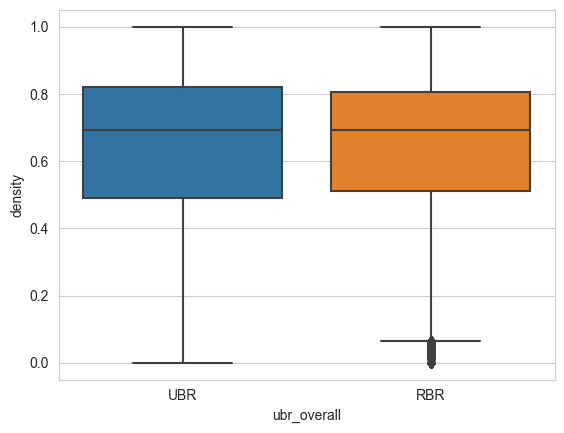

In [78]:
sns.boxplot(data=person_ehr_density_df, x="ubr_overall", y="density")

#### UBR SEX

In [79]:
person_ehr_density_df[['ubr_sex', 'density']].groupby('ubr_sex').describe()

density                                                         \
                 count      mean       std  min       25%       50%       75%   
ubr_sex                                                                         
RBR           391525.0  0.632368  0.233575  0.0  0.494774  0.692624  0.817166   
SKIP/UNKNOWN    3975.0  0.632774  0.241058  0.0  0.484507  0.698154  0.823430   
UBR              222.0  0.596472  0.248700  0.0  0.444862  0.659856  0.790868   

                        
                   max  
ubr_sex                 
RBR           1.000000  
SKIP/UNKNOWN  1.000000  
UBR           0.962827

<Axes: xlabel='ubr_sex', ylabel='density'>

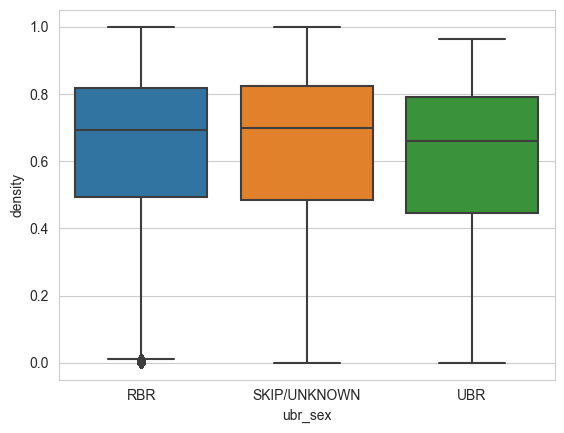

In [80]:
sns.boxplot(data=person_ehr_density_df, x="ubr_sex", y="density")

#### UBR SEXUAL ORIENTATION

In [84]:
person_ehr_density_df[['ubr_sexual_orientation', 'density']].groupby('ubr_sexual_orientation').describe()

density                                               \
                           count      mean       std  min       25%       50%   
ubr_sexual_orientation                                                          
RBR                     349631.0  0.635050  0.233110  0.0  0.498641  0.696057   
SKIP/UNKNOWN              9900.0  0.614208  0.244668  0.0  0.461486  0.673515   
UBR                      36191.0  0.611248  0.234605  0.0  0.469193  0.665200   

                                       
                             75%  max  
ubr_sexual_orientation                 
RBR                     0.819244  1.0  
SKIP/UNKNOWN            0.811298  1.0  
UBR                     0.796235  1.0

<Axes: xlabel='ubr_sexual_orientation', ylabel='density'>

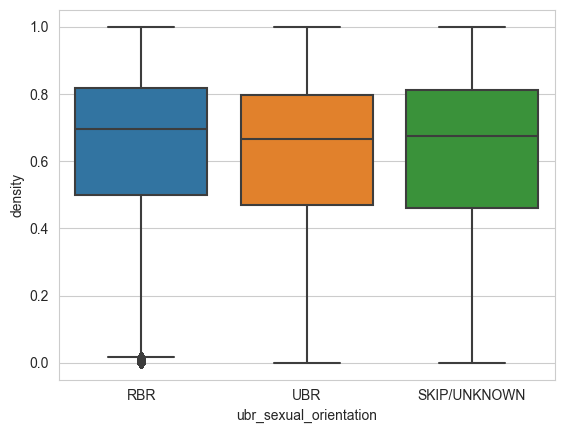

In [85]:
sns.boxplot(data=person_ehr_density_df, x="ubr_sexual_orientation", y="density")

#### UBR SEXUAL GENDER MINORITY

In [86]:
person_ehr_density_df[['ubr_sexual_gender_minority', 'density']].groupby('ubr_sexual_gender_minority').describe()

density                                     \
                               count      mean       std  min       25%   
ubr_sexual_gender_minority                                                
RBR                         346375.0  0.635074  0.233000  0.0  0.498714   
SKIP/UNKNOWN                 11833.0  0.620911  0.245096  0.0  0.469847   
UBR                          37514.0  0.610828  0.234835  0.0  0.468828   

                                                     
                                 50%       75%  max  
ubr_sexual_gender_minority                           
RBR                         0.696018  0.819137  1.0  
SKIP/UNKNOWN                0.683416  0.818996  1.0  
UBR                         0.664608  0.795951  1.0

<Axes: xlabel='ubr_sexual_gender_minority', ylabel='density'>

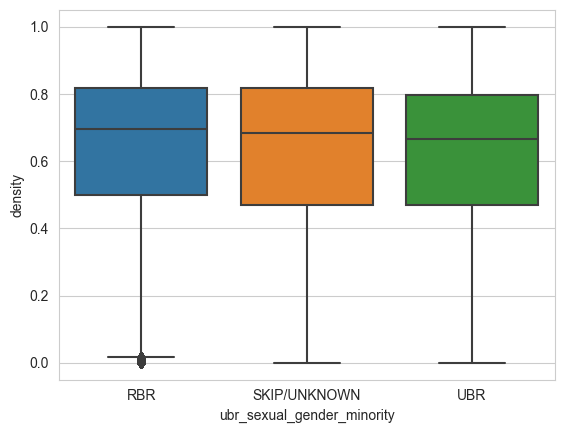

In [87]:
sns.boxplot(data=person_ehr_density_df, x="ubr_sexual_gender_minority", y="density")

#### UBR GENDER IDENTITY

In [82]:
person_ehr_density_df[['ubr_gender_identity', 'density']].groupby('ubr_gender_identity').describe()

density                                               \
                        count      mean       std  min       25%       50%   
ubr_gender_identity                                                          
RBR                  387761.0  0.632675  0.233502  0.0  0.495231  0.693049   
SKIP/UNKNOWN           3505.0  0.627943  0.251262  0.0  0.469280  0.698970   
UBR                    4456.0  0.607716  0.231829  0.0  0.467602  0.656301   

                                    
                          75%  max  
ubr_gender_identity                 
RBR                  0.817304  1.0  
SKIP/UNKNOWN         0.833379  1.0  
UBR                  0.790040  1.0

<Axes: xlabel='ubr_gender_identity', ylabel='density'>

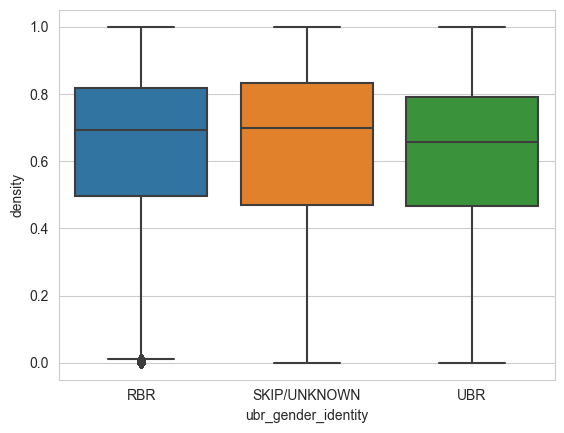

In [83]:
sns.boxplot(data=person_ehr_density_df, x="ubr_gender_identity", y="density")

#### UBR ETHNICITY

In [89]:
person_ehr_density_df[['ubr_ethnicity', 'density']].groupby('ubr_ethnicity').describe()

density                                               \
                  count      mean       std  min       25%       50%   
ubr_ethnicity                                                          
RBR            212001.0  0.666045  0.220600  0.0  0.551532  0.729370   
SKIP/UNKNOWN     7053.0  0.639353  0.239527  0.0  0.501596  0.703946   
UBR            176668.0  0.591641  0.242044  0.0  0.435295  0.643199   

                              
                    75%  max  
ubr_ethnicity                 
RBR            0.835234  1.0  
SKIP/UNKNOWN   0.831675  1.0  
UBR            0.785362  1.0

<Axes: xlabel='ubr_ethnicity', ylabel='density'>

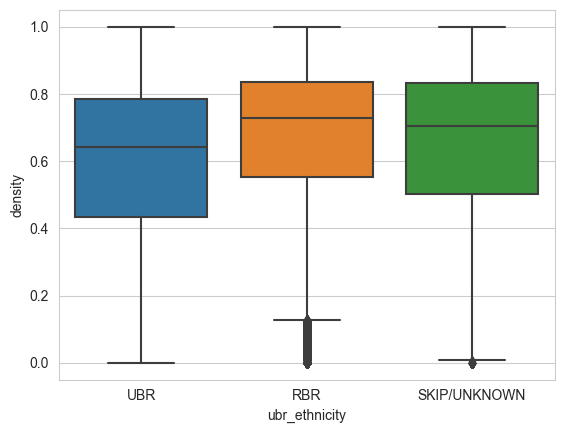

In [90]:
sns.boxplot(data=person_ehr_density_df, x="ubr_ethnicity", y="density")

#### UBR GEOGRAPHY

In [91]:
person_ehr_density_df[['ubr_geography', 'density']].groupby('ubr_geography').describe()

density                                                    \
                  count      mean       std       min       25%       50%   
ubr_geography                                                               
RBR            367279.0  0.629283  0.233973  0.000000  0.490493  0.689038   
SKIP/UNKNOWN        1.0  0.414171       NaN  0.414171  0.414171  0.414171   
UBR             28442.0  0.671989  0.225887  0.000000  0.553464  0.739644   

                                   
                    75%       max  
ubr_geography                      
RBR            0.814496  1.000000  
SKIP/UNKNOWN   0.414171  0.414171  
UBR            0.846246  1.000000

<Axes: xlabel='ubr_geography', ylabel='density'>

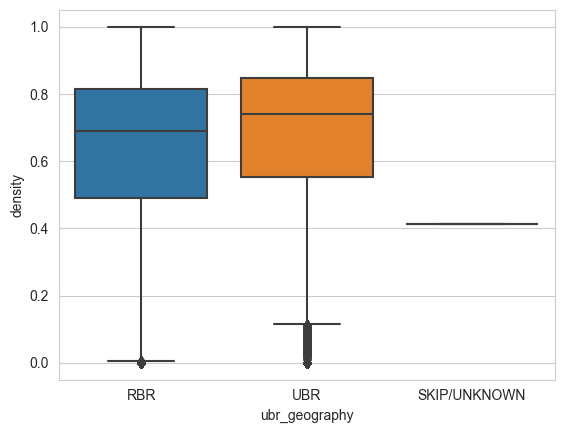

In [92]:
sns.boxplot(data=person_ehr_density_df, x="ubr_geography", y="density")

#### UBR EDUCATION

In [95]:
person_ehr_density_df[['ubr_education', 'density']].groupby('ubr_education').describe()

density                                               \
                  count      mean       std  min       25%       50%   
ubr_education                                                          
RBR            351814.0  0.637646  0.231808  0.0  0.503082  0.698862   
SKIP/UNKNOWN     9264.0  0.601520  0.245238  0.0  0.444606  0.654845   
UBR             34644.0  0.586834  0.243447  0.0  0.431160  0.637696   

                              
                    75%  max  
ubr_education                 
RBR            0.820277  1.0  
SKIP/UNKNOWN   0.802477  1.0  
UBR            0.781869  1.0

<Axes: xlabel='ubr_education', ylabel='density'>

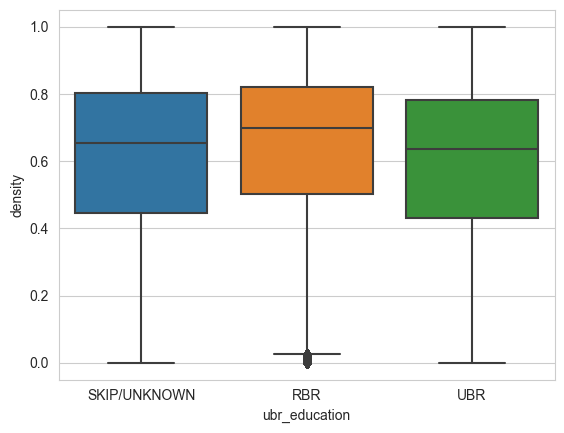

In [96]:
sns.boxplot(data=person_ehr_density_df, x="ubr_education", y="density")

#### UBR INCOME

In [93]:
person_ehr_density_df[['ubr_income', 'density']].groupby('ubr_income').describe()

density                                                         \
                 count      mean       std  min       25%       50%       75%   
ubr_income                                                                      
RBR           220149.0  0.650809  0.225908  0.0  0.526667  0.713312  0.826427   
SKIP/UNKNOWN   82012.0  0.609238  0.239283  0.0  0.457265  0.664657  0.801440   
UBR            93561.0  0.609183  0.242579  0.0  0.460477  0.664159  0.803599   

                   
              max  
ubr_income         
RBR           1.0  
SKIP/UNKNOWN  1.0  
UBR           1.0

<Axes: xlabel='ubr_income', ylabel='density'>

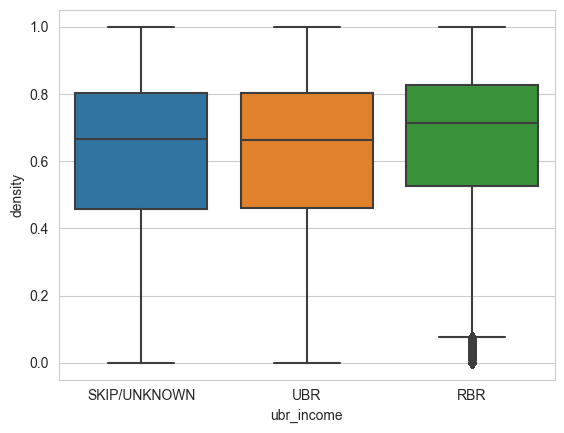

In [94]:
sns.boxplot(data=person_ehr_density_df, x="ubr_income", y="density")

#### UBR AGE AT CONSENT

In [98]:
person_ehr_density_df[['ubr_age_at_consent', 'density']].groupby('ubr_age_at_consent').describe()

density                                               \
                       count      mean       std  min       25%       50%   
ubr_age_at_consent                                                          
RBR                 285683.0  0.606680  0.234747  0.0  0.463765  0.661106   
UBR                 110039.0  0.699001  0.217080  0.0  0.598147  0.770104   

                                   
                         75%  max  
ubr_age_at_consent                 
RBR                 0.792389  1.0  
UBR                 0.859873  1.0

<Axes: xlabel='ubr_age_at_consent', ylabel='density'>

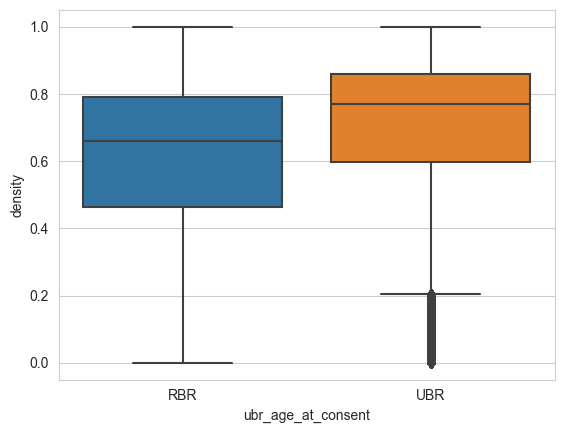

In [99]:
sns.boxplot(data=person_ehr_density_df, x="ubr_age_at_consent", y="density")

## Remote vs. in-person biosample donation

<Axes: xlabel='bbo_collection_method', ylabel='density'>

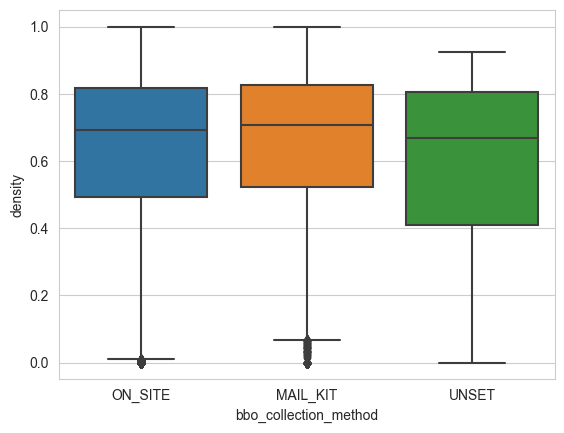

In [100]:
sns.boxplot(data=person_ehr_density_df, x="bbo_collection_method", y="density")

## Patient vs. non-patient status at HPO

<Axes: xlabel='patient_status', ylabel='density'>

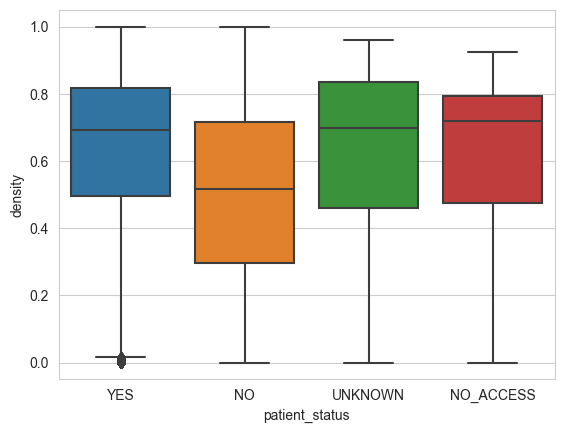

In [102]:
sns.boxplot(data=person_ehr_density_df, x="patient_status", y="density")

## The average number of EHR records per participant across each domain
#### - Conditions
#### - Procedures
#### - Drugs
#### - Labs and measurements
#### - Visits
#### - Observations
#### - Devices

In [123]:
event_per_person_query = f"""
SELECT DISTINCT 
    person_id, 
    event_type, 
    COUNT(DISTINCT event_id) AS event_cnt_per_person
FROM `{EHR_OPS_PROJECT_ID}.{EHR_DENSITY_DATASET_ID}.unioned_event`
GROUP BY 1,2
"""

In [124]:
event_per_person_df = client.query(event_per_person_query).to_dataframe()

In [125]:
event_per_person_df[['event_type', 'event_cnt_per_person']].groupby('event_type').mean()

,event_cnt_per_person
event_type,
condition,381.144458
drug,357.459683
measurement,1542.668276
procedure,121.981384


## The average duration between the first and last EHR record per participant across each of the above domains

In [116]:
ehr_duration_per_person_query = f"""
SELECT 
  person_id, 
  event_type,
  MAX(event_datetime) as max_event_datetime, 
  MIN(event_datetime) as min_event_datetime,
  TIMESTAMP_DIFF(MAX(event_datetime), MIN(event_datetime), DAY) AS total_days_diff
FROM `{EHR_OPS_PROJECT_ID}.{EHR_DENSITY_DATASET_ID}.unioned_event`
GROUP BY 1,2
"""

In [117]:
ehr_duration_per_person_df = client.query(ehr_duration_per_person_query).to_dataframe()

In [122]:
ehr_duration_per_person_df.groupby('event_type')['total_days_diff'].mean()

event_type
condition      3814.905602
drug           3478.218737
measurement    3486.154863
procedure      3668.074977
Name: total_days_diff, dtype: Float64